### 0. Import Libraries

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)  #used for to avoid exponential values
pd.options.display.max_rows=50

### 1. Import Datasets
Train dataset shows the sensor-based time-series until the timepoint the engine breaks down.

Test dataset constitute of sensor-based time-series a “random” time before the endpoint.

Truth contains the true values for remaining useful life to which we are going to compare our predicted values in the test set.

In [284]:
train_df = pd.read_excel('Dataset/PM_train.xlsx')

In [7]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044


In [9]:
train_df.shape

(20631, 26)

In [84]:
test_df = pd.read_excel('Dataset/PM_test.xlsx')

In [86]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392.0,2388,100,38.86,23.3735
1,1,2,-0.0027,-0.0003,100,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393.0,2388,100,39.02,23.3916
2,1,3,0.0003,0.0001,100,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393.0,2388,100,39.08,23.4166
3,1,4,0.0042,0.0000,100,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391.0,2388,100,39.00,23.3737
4,1,5,0.0014,0.0000,100,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390.0,2388,100,38.99,23.4130


In [88]:
test_df.shape

(11939, 26)

In [13]:
truth_df = pd.read_excel('Dataset/PM_truth.xlsx')

In [92]:
truth_df.head()

,more,id
0,98,1
1,69,2
2,82,3
3,91,4
4,93,5


In [94]:
truth_df.shape

(99, 2)

<Axes: xlabel='more', ylabel='Count'>

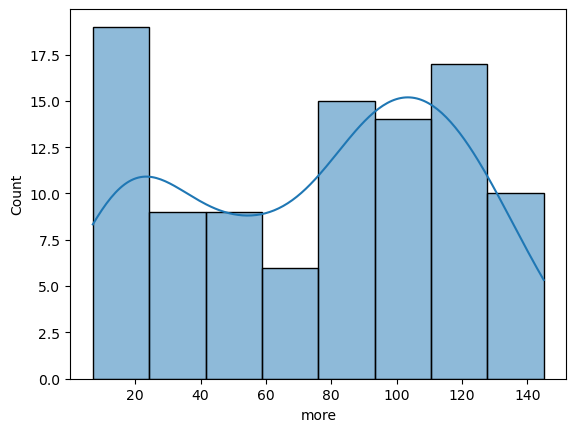

In [151]:
sns.histplot(truth_df['more'], kde=True)

In [154]:
truth_df['more'].describe()

count     99.000000
mean      75.151515
std       41.813816
min        7.000000
25%       31.500000
50%       85.000000
75%      112.000000
max      145.000000
Name: more, dtype: float64

### 2. Data Exploration
Firstly, I looked at how many observations have the same ID

In [101]:
train_df.id.value_counts()

id
69    362
92    341
96    336
67    313
83    293
     ... 
24    147
57    137
70    137
91    135
39    128
Name: count, Length: 100, dtype: int64

In [103]:
test_df.id.value_counts()

id
49    303
91    234
62    232
12    217
81    213
     ... 
14     46
22     39
39     37
85     34
1      31
Name: count, Length: 92, dtype: int64

I observed we have 100 id in train, 92 id in test, and 99 id in truth. Something is wrong?

In [180]:
train_df.describe()

,id,cycle,setting1,setting2,s2,s3,s4,s5,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
count,20631.000,20631.000,20631.000,20631.000,20631.000,20631.000,20631.000,20631.000,20631.000,20631.000,20631.000,20631.000,20631.000,20631.000,20631.000,20631.000,20631.000,20631.000,20631.000,20631.000
mean,51.507,108.808,-0.000,0.000,642.681,1590.523,1408.934,14.620,21.610,553.368,2388.097,9065.243,47.541,521.413,2388.096,8143.753,8.442,393.211,38.816,23.290
std,29.228,68.881,0.002,0.000,0.500,6.131,9.001,0.000,0.001,0.885,0.071,22.083,0.267,0.738,0.072,19.076,0.038,1.549,0.181,0.108
min,1.000,1.000,-0.009,-0.001,641.210,1571.040,1382.250,14.620,21.600,549.850,2387.900,9021.730,46.850,518.690,2387.880,8099.940,8.325,388.000,38.140,22.894
25%,26.000,52.000,-0.002,-0.000,642.325,1586.260,1402.360,14.620,21.610,552.810,2388.050,9053.100,47.350,520.960,2388.040,8133.245,8.415,392.000,38.700,23.222
50%,52.000,104.000,0.000,0.000,642.640,1590.100,1408.040,14.620,21.610,553.440,2388.090,9060.660,47.510,521.480,2388.090,8140.540,8.439,393.000,38.830,23.298
75%,77.000,156.000,0.002,0.000,643.000,1594.380,1414.555,14.620,21.610,554.010,2388.140,9069.420,47.700,521.950,2388.140,8148.310,8.466,394.000,38.950,23.367
max,100.000,362.000,0.009,0.001,644.530,1616.910,1441.490,14.620,21.610,556.060,2388.560,9244.590,48.530,523.380,2388.560,8293.720,8.585,400.000,39.430,23.618


Notice that some of the sensors have the same min and max. Also std is 0.  
In time-series, this is called a flat line, which means there is no activity

In [178]:
test_df.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,11939.000,11939.000,11939.000,11939.000,11939.000,11939.000,11939.000,11939.000,11939.000,11939.000,...,11939.000,11939.000,11939.000,11939.000,11939.000,11939.000,11939.000,11939.000,11939.000,11939.000
mean,47.219,76.402,-0.000,0.000,100.000,518.670,642.474,1588.089,1404.705,14.619,...,521.747,2388.072,8138.532,8.426,0.030,392.566,2388.000,100.000,38.893,23.336
std,25.797,52.751,0.002,0.000,0.000,0.000,0.400,4.999,6.662,0.125,...,0.558,0.057,9.872,0.029,0.000,1.225,0.000,0.000,0.141,0.084
min,1.000,1.000,-0.008,-0.001,100.000,518.670,641.130,1569.040,1384.390,1.000,...,519.380,2387.890,8108.500,8.333,0.030,389.000,2388.000,100.000,38.310,22.935
25%,25.000,33.000,-0.002,-0.000,100.000,518.670,642.190,1584.580,1399.950,14.620,...,521.380,2388.030,8131.980,8.406,0.030,392.000,2388.000,100.000,38.800,23.282
50%,49.000,68.000,0.000,0.000,100.000,518.670,642.460,1587.990,1404.410,14.620,...,521.780,2388.070,8137.920,8.425,0.030,393.000,2388.000,100.000,38.900,23.339
75%,68.000,112.000,0.002,0.000,100.000,518.670,642.740,1591.350,1408.950,14.620,...,522.140,2388.110,8144.020,8.444,0.030,393.000,2388.000,100.000,38.990,23.394
max,92.000,303.000,0.008,0.001,100.000,518.670,644.300,1607.550,1433.360,14.620,...,523.760,2388.320,8218.130,8.541,0.030,397.000,2388.000,100.000,39.410,23.642


Setting 3, s1, s5, s10, s16, s18 and s19 should be removed.

In [308]:
train_df.drop(columns = ['setting3', 's1', 's5', 's10', 's16', 's18', 's19'], inplace=True)

In [310]:
print(train_df.columns)

Index(['id', 'cycle', 'setting1', 'setting2', 's2', 's3', 's4', 's6', 's7',
       's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21'],
      dtype='object')


In [314]:
print(test_df.columns)

Index(['id', 'cycle', 'setting1', 'setting2', 's2', 's3', 's4', 's6', 's7',
       's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21'],
      dtype='object')


Let’s check out the distribution of the columns in the train set. In this way, we can check the extreme values and flat lines.

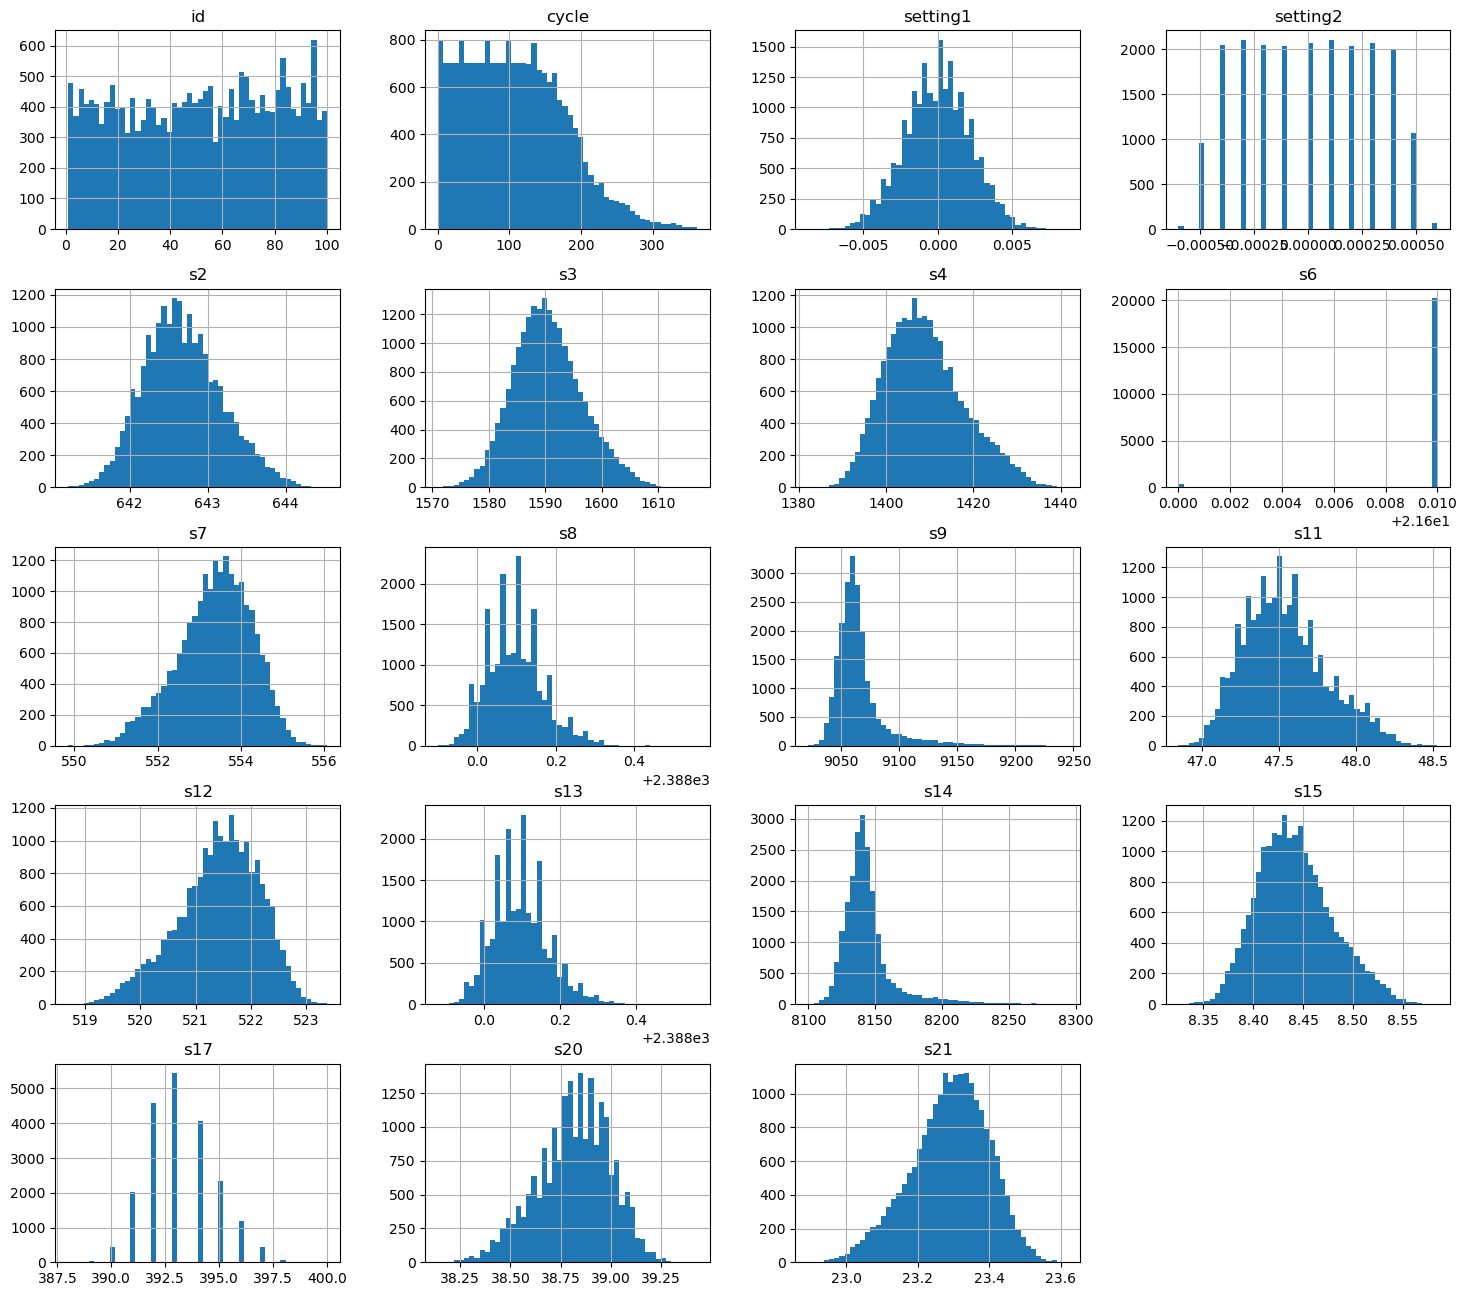

In [255]:
train_df.hist(bins=50, figsize=(18,16))
plt.show()

Now, let’s check out the distribution of the columns in the test set.

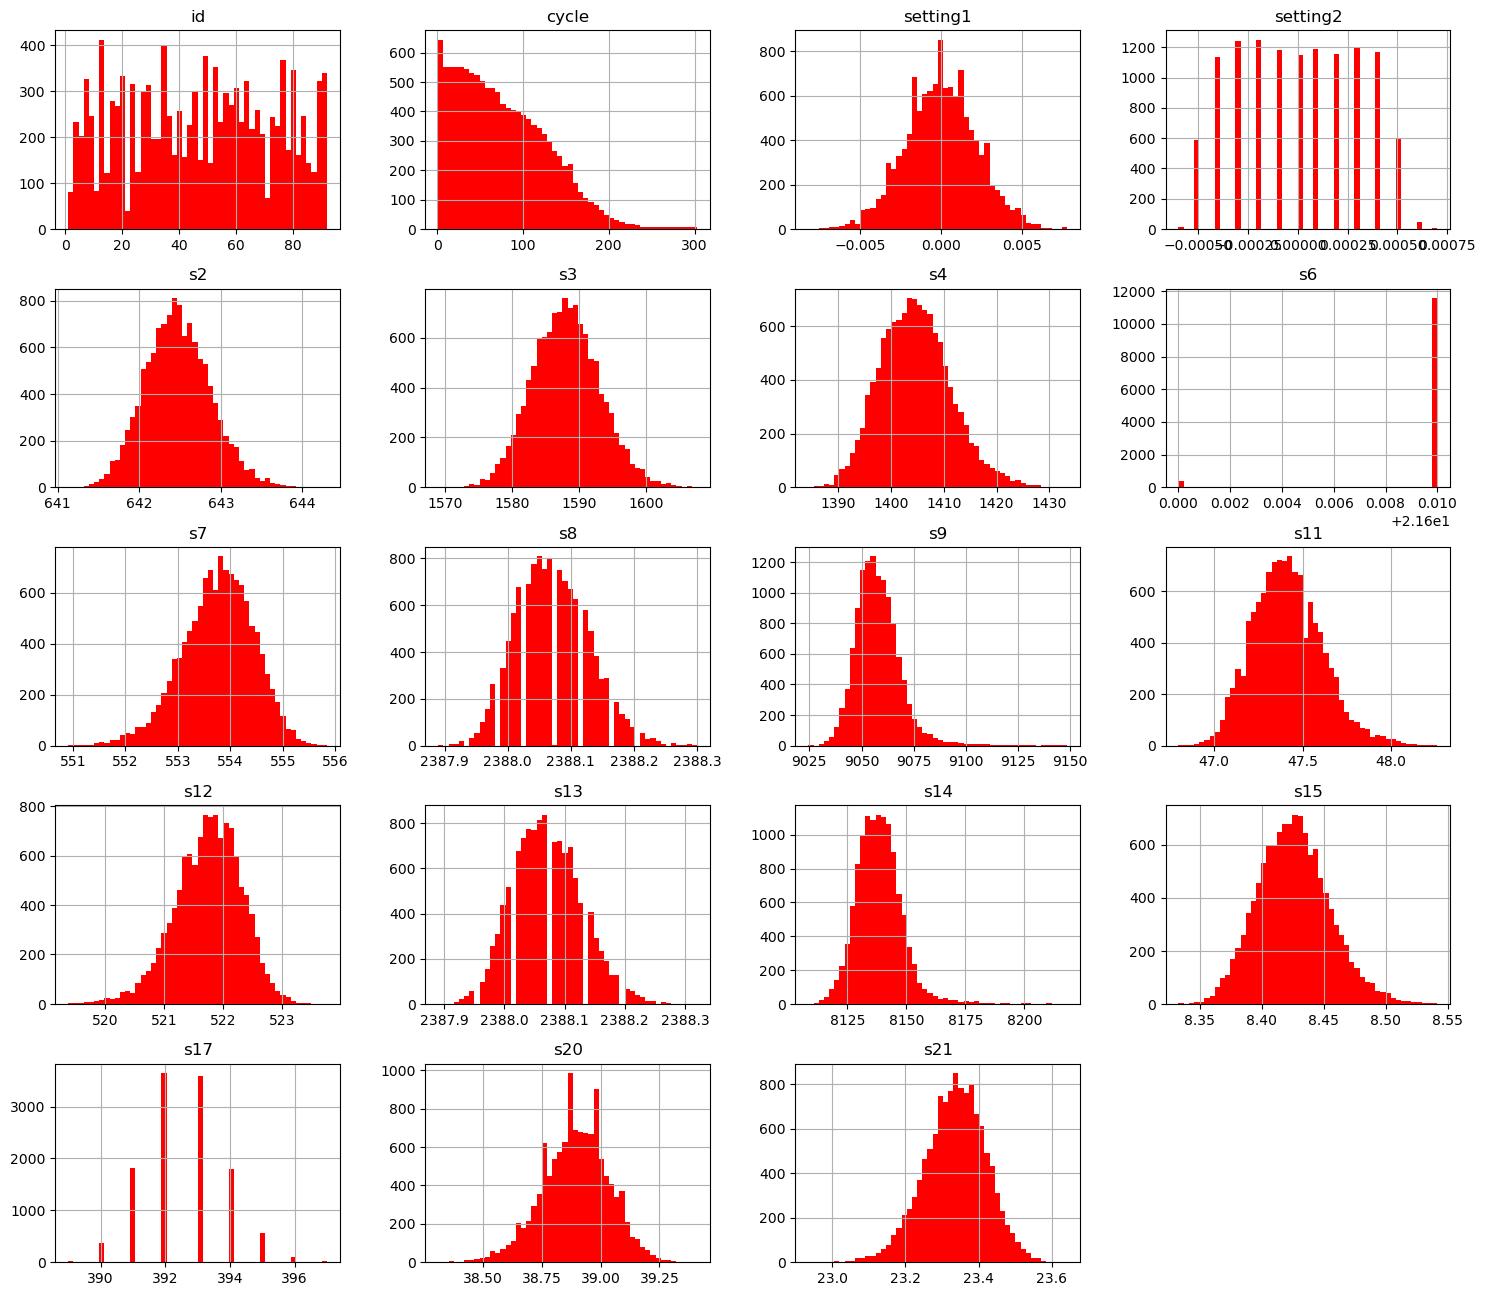

In [257]:
test_df.hist(bins=50, figsize=(18,16), color="red")
plt.show()

All the sensor datas seems useful. There are no extreme values or flat lines.

Checking the mean and the standart deviation of train and test:

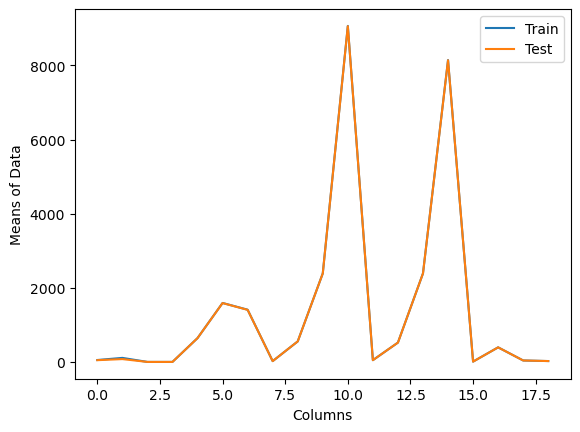

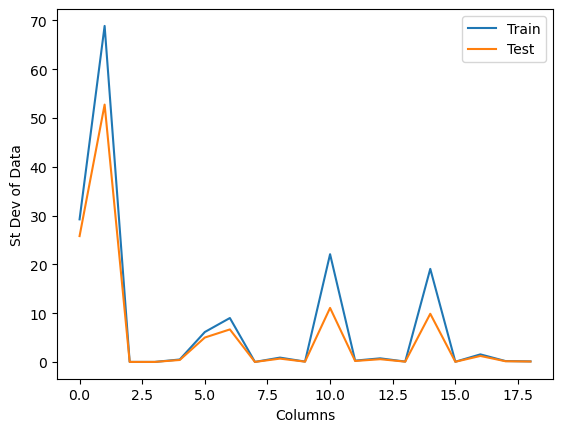

In [271]:
train_stats = train_df.describe()
test_stats = test_df.describe()
plt.plot(range(len(train_stats.columns)),train_stats.iloc[1,:])
plt.plot(range(len(test_stats.columns)),test_stats.iloc[1,:])
plt.xlabel("Columns")
plt.ylabel("Means of Data")
plt.legend(['Train','Test'])
plt.show()


# and then the stddevs
plt.plot(range(len(train_stats.columns)),train_stats.iloc[2,:])
plt.plot(range(len(test_stats.columns)),test_stats.iloc[2,:])
plt.xlabel("Columns")
plt.ylabel("St Dev of Data")
plt.legend(['Train','Test'])
plt.show()

Checking the correlations:

In [302]:
train_df.columns

Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21'],
      dtype='object')

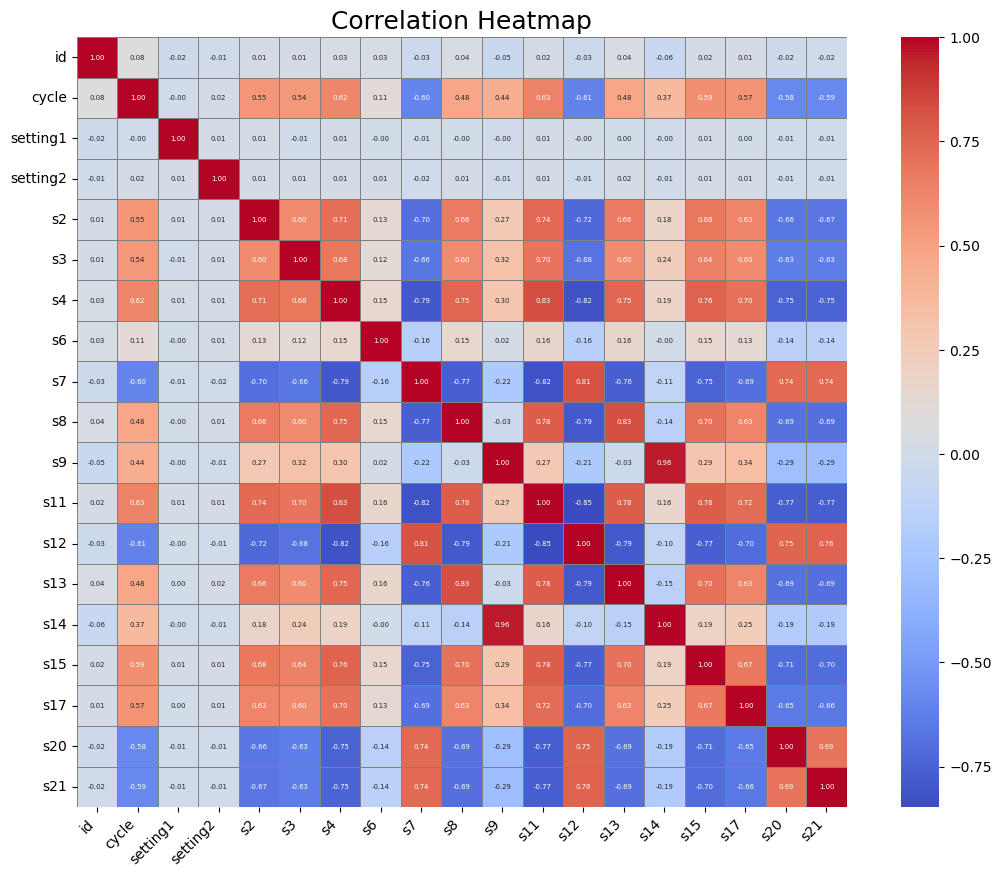

In [360]:
corr_matrix = train_df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, 
            annot=True,        # Hücrelerin içinde değerleri gösterir
            fmt=".2f",         # Değer formatı
            cmap="coolwarm",   # Renk paleti
            cbar=True,         # Renk skalası ekler
            annot_kws={"size": 5}, # Değerlerin yazı boyutu
            linewidths=.4,     # Hücreler arası çizgi genişliği
            linecolor='gray',  # Hücreler arası çizgi rengi
            square=True        # Hücrelerin kare şeklinde olmasını sağlar
           )
plt.title('Correlation Heatmap', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10) # X eksenindeki etiketleri döndür ve hizala
plt.yticks(rotation=0, fontsize=10)              # Y eksenindeki etiketleri hizala

plt.show()

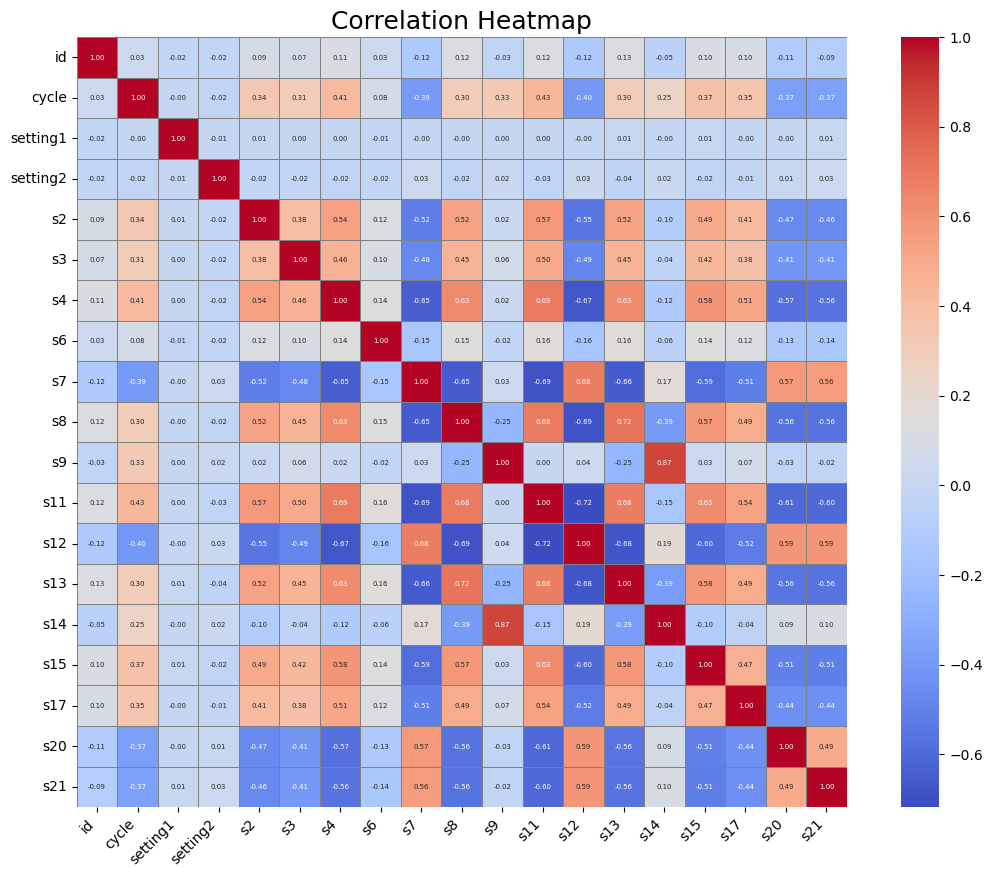

In [322]:
corr_matrix = test_df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, 
            annot=True,        # Hücrelerin içinde değerleri gösterir
            fmt=".2f",         # Değer formatı
            cmap="coolwarm",   # Renk paleti
            cbar=True,         # Renk skalası ekler
            annot_kws={"size": 5}, # Değerlerin yazı boyutu
            linewidths=.4,     # Hücreler arası çizgi genişliği
            linecolor='gray',  # Hücreler arası çizgi rengi
            square=True        # Hücrelerin kare şeklinde olmasını sağlar
           )
plt.title('Correlation Heatmap', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10) # X eksenindeki etiketleri döndür ve hizala
plt.yticks(rotation=0, fontsize=10)              # Y eksenindeki etiketleri hizala

plt.show()

Exploratory Analyses of the Maximum Number of Cycles per IDs.

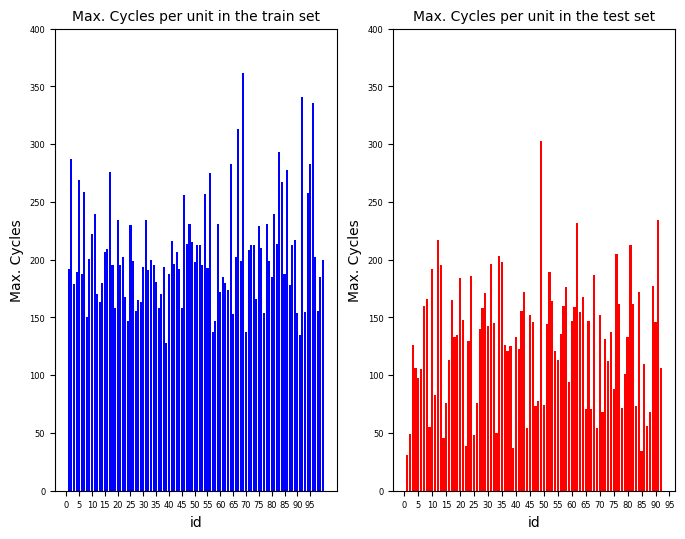

In [352]:
cyclestrain = train_df.groupby('id', as_index=False)['cycle'].max()
cyclestest = test_df.groupby('id', as_index=False)['cycle'].max()
fig = plt.figure(figsize = (8,6))
fig.add_subplot(1,2,1)
bar_labels = list(cyclestrain['id'])
bars = plt.bar(list(cyclestrain['id']), cyclestrain['cycle'], color='blue')
plt.ylim([0, 400])
plt.xlabel('id', fontsize=10)
plt.ylabel('Max. Cycles', fontsize=10)
plt.title('Max. Cycles per unit in the train set', fontsize=10)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=6)
plt.yticks(fontsize=6)
fig.add_subplot(1,2,2)
bars = plt.bar(list(cyclestest['id']), cyclestest['cycle'], color='red')
plt.ylim([0, 400])
plt.xlabel('id', fontsize=10)
plt.ylabel('Max. Cycles', fontsize=10)
plt.title('Max. Cycles per unit in the test set', fontsize=10)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=6)
plt.yticks(fontsize=6)
plt.show()

Nothing wrongs in here. Let's analyze the datasets by columns.

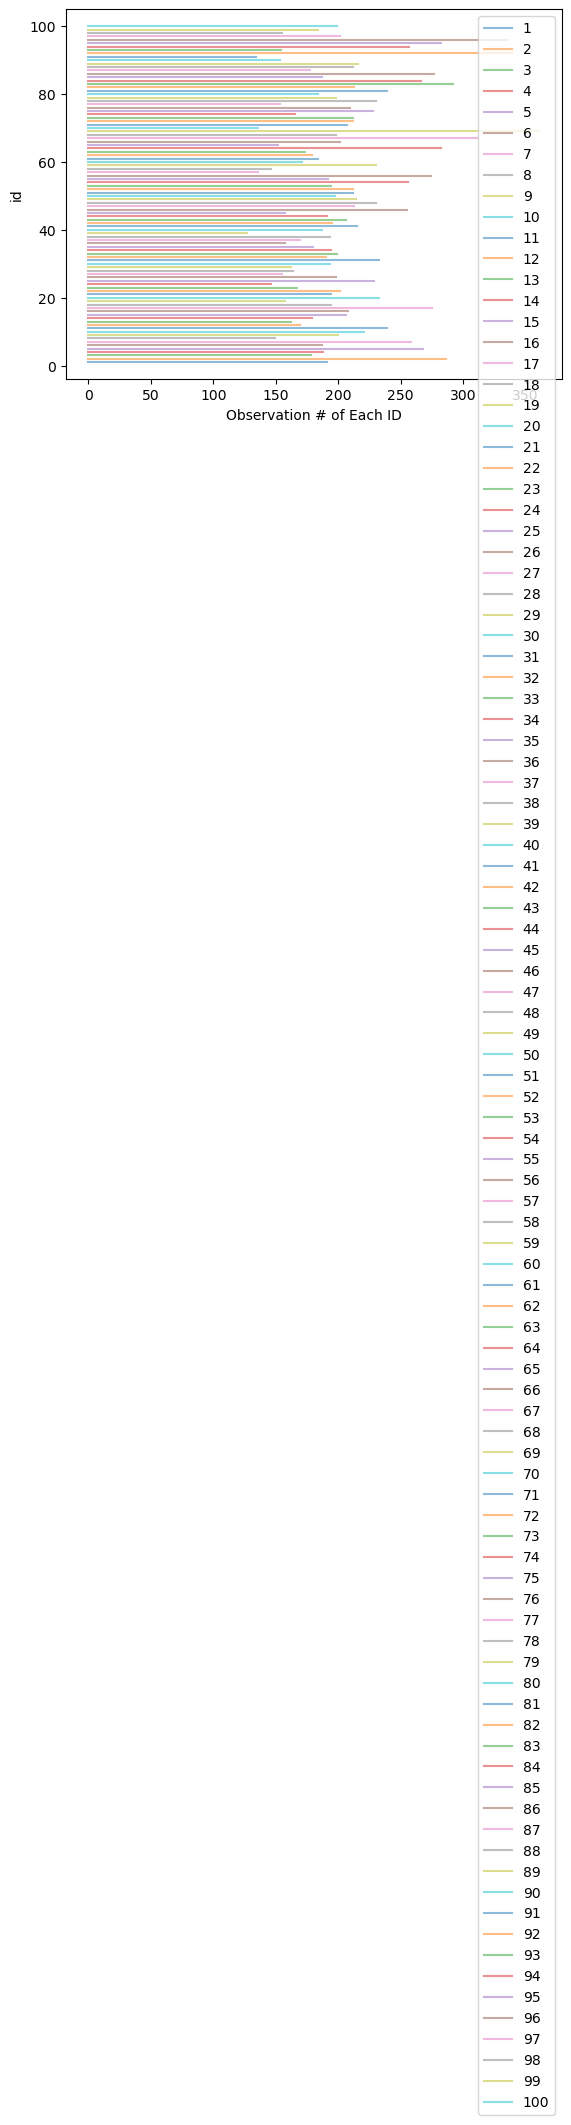

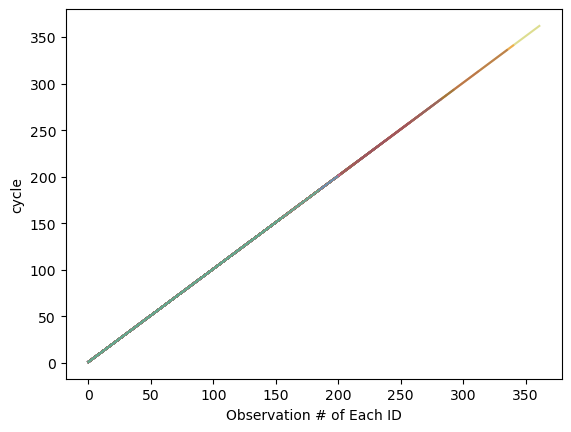

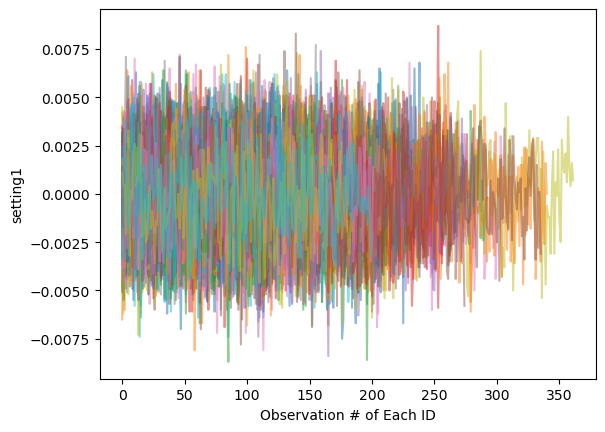

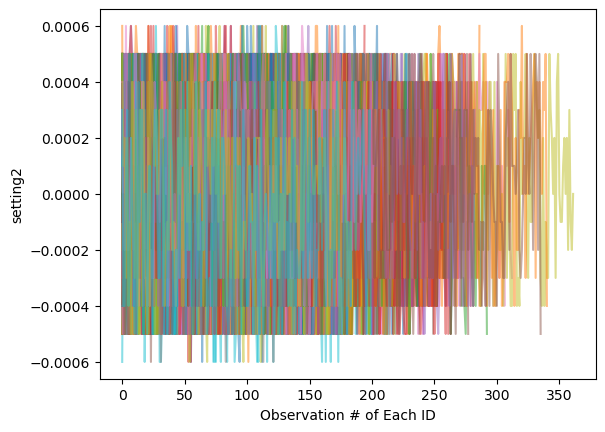

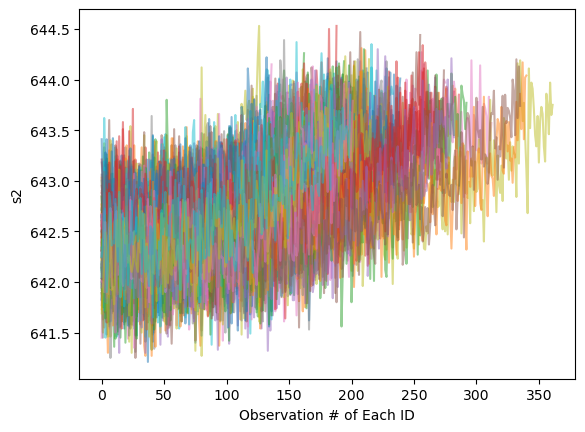

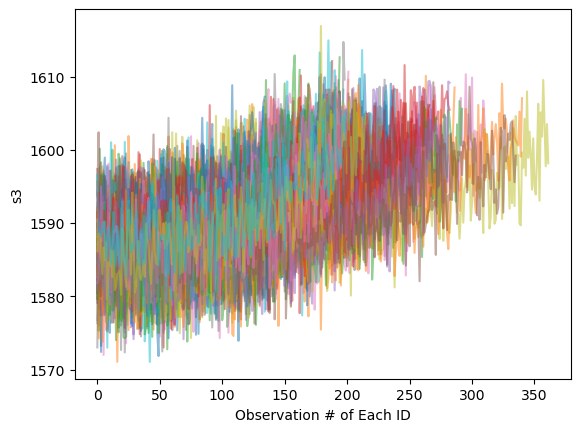

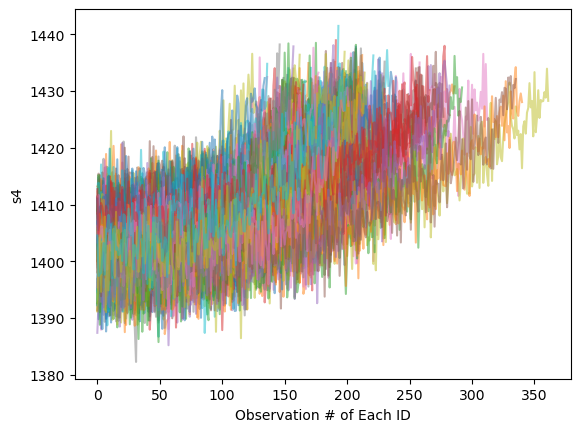

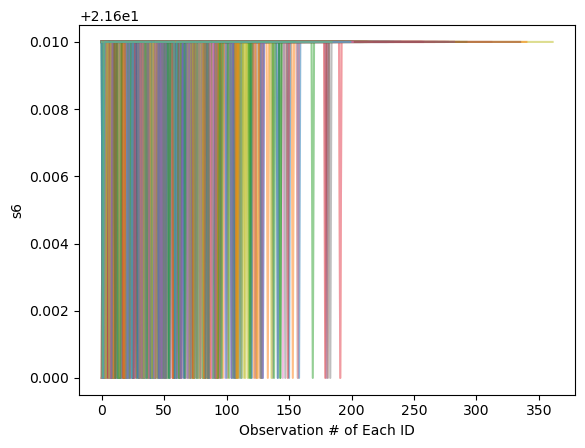

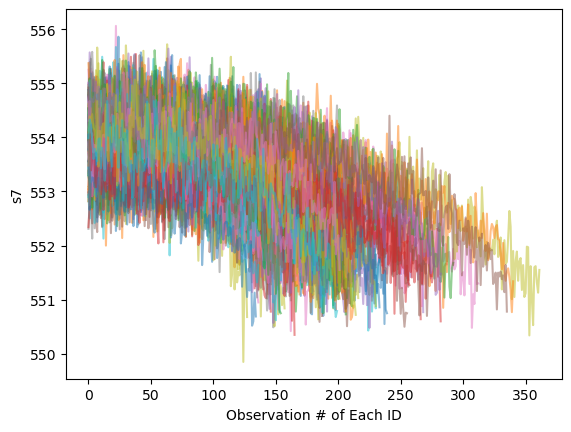

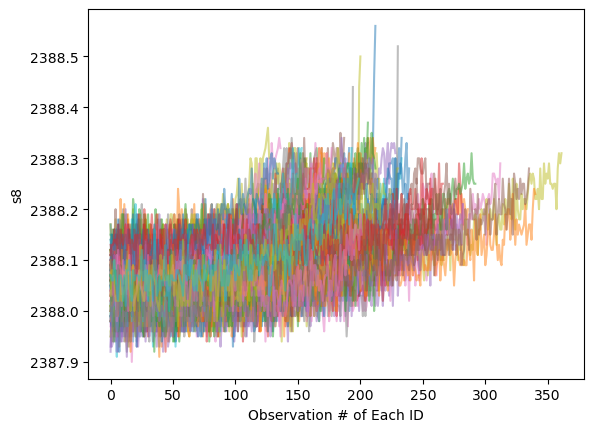

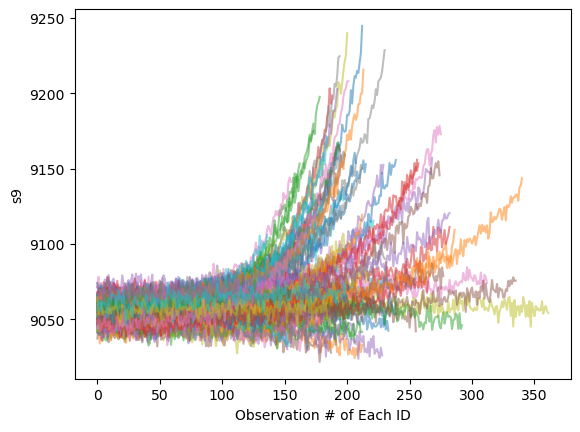

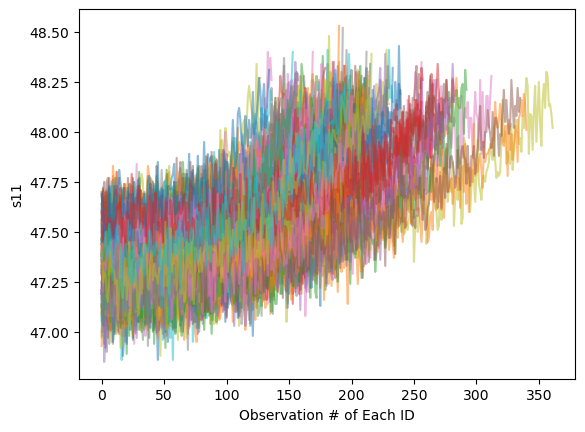

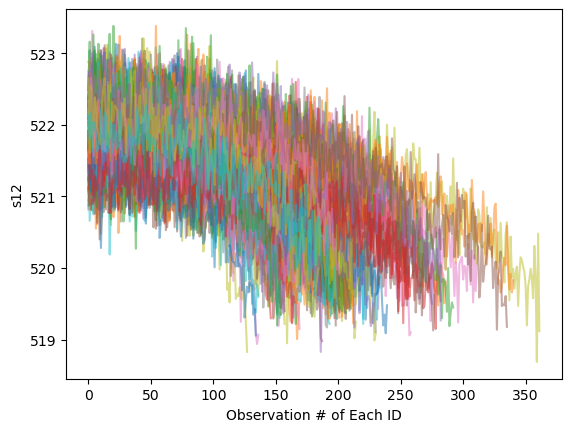

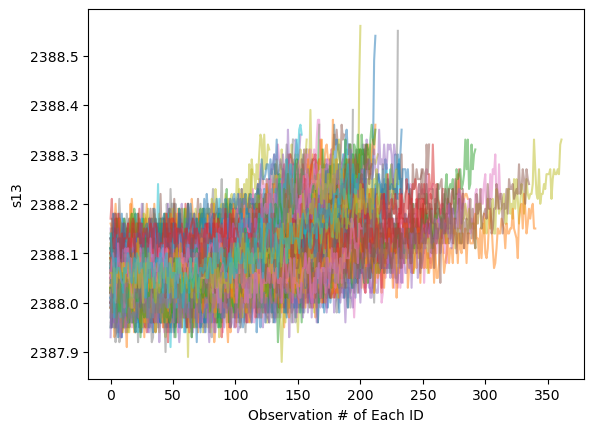

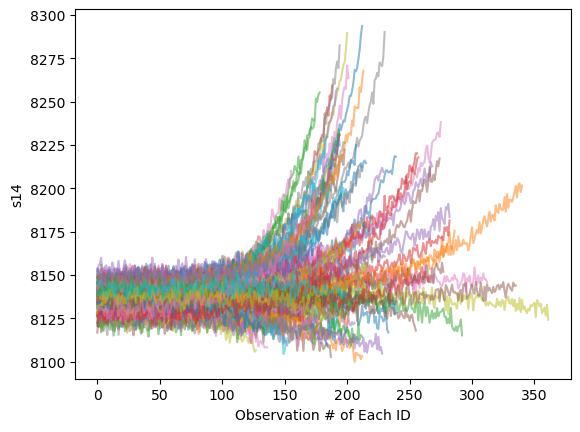

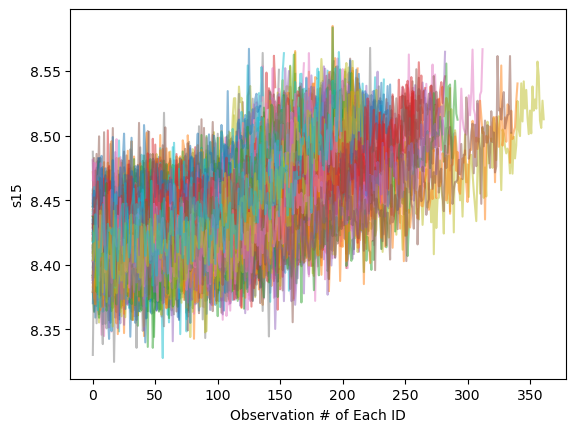

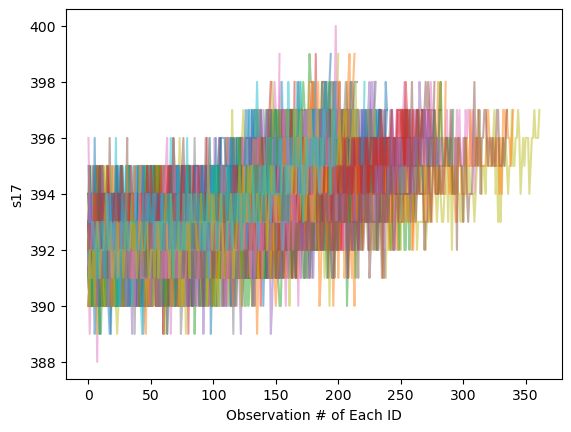

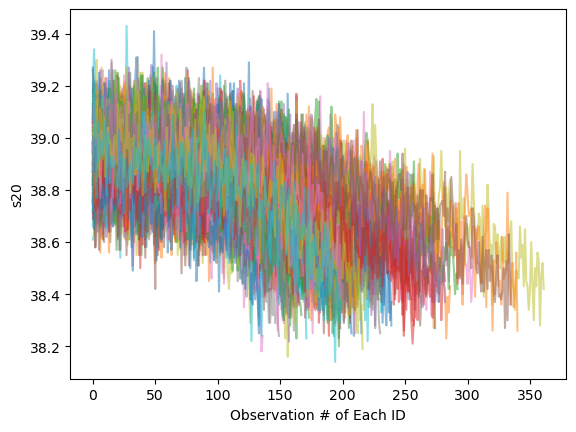

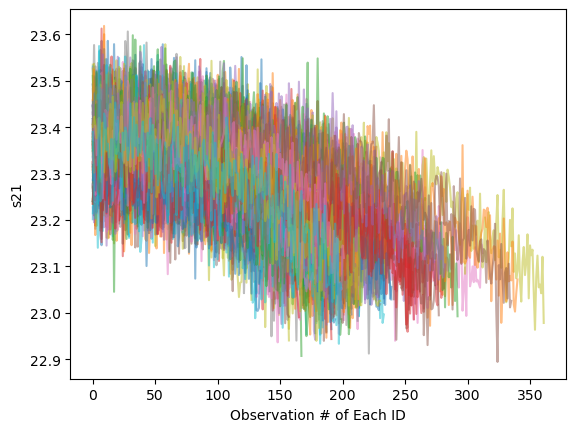

In [261]:
ids = train_df.id.unique()
for j in range(len(train_df.columns)):
    labels = []
    for i in range(len(ids)):
        plt.plot(range(len(train_df.iloc[:,j].loc[train_df.id == ids[i]])),
                 train_df.iloc[:,j].loc[train_df.id == ids[i]],
                 alpha=.5)
        labels.append(ids[i])
    if j == 0:
        plt.legend(labels)
    plt.ylabel(train_df.columns[j])
    plt.xlabel("Observation # of Each ID")
    plt.show()

All the plots are logical. 